In [12]:
import sequtils as sue
from Bio import SeqIO
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import baltic as bt
from pprint import pprint
from matplotlib import cm
from numpy import linspace
from collections import defaultdict
import pandas as pd

In [31]:
tree = bt.loadJSON('/Users/Sidney/Desktop/genotype_ref/dengue_all_tree.json')


Tree height: 406.073140
Tree length: 9548.312420
annotations present

Numbers of objects in tree: 1719 (821 nodes and 898 leaves)



In [32]:
## Data structures
genotype_accessions = defaultdict(list) # { genotype: [accessions]}
genotype_map = defaultdict(list) # { genotype: [strains]}
ref_strains = {} # {strain: genotype}
missing_accs = []

## Input data
pyke_refs = pd.read_csv('../data/reference_seqs/genotype_refs_pyke2016.csv', header=None, names=['sero', 'geno', 'year', 'acc', 'country', 'strain']).to_dict(orient='records')
katzelnick_refs = [i.description.split('|')[0] for i in sue.load('../data/reference_seqs/genotype_ref.fasta')]
fauna_strains = { i.description.split('|')[1]: i.description.split('|')[0] for i in sue.load('/Users/Sidney/nextstrain/fauna/data/dengue_all.fasta')}

## Parse
for record in pyke_refs:
    genotype_accessions[record['sero']+'_'+record['geno']].append(record['acc'])
for genotype, accessions in genotype_accessions.items():
    for accession in accessions:
        if accession in fauna_strains:
            strain = fauna_strains[accession]
            genotype_map[genotype.upper()].append(strain)
            ref_strains[strain] = genotype.upper()
        else:
            missing_accs.append(accession)
            
for strain in katzelnick_refs:
    fields = strain.split('/')
    genotype = fields[0]+'_'+fields[2]
    genotype_map[genotype.upper()].append(strain)
    ref_strains[strain] = genotype.upper()
    
genotype_map = dict(genotype_map)
DENV1_V_MAP = genotype_map.pop('DENV1_V')
DENV1_IV_MAP = genotype_map.pop('DENV1_IV')
genotype_accessions = dict(genotype_accessions)
pprint(genotype_map)

## Helper util
def is_genotype_reference(tip):
    return tip.traits['strain'] in ref_strains

{'DENV1_I': ['DENV1/JAPAN/MOCHIZUKI/1943',
             'DENV1/USA/NA/1944',
             'DENV1/THAILAND/0008/1981',
             'DENV1/SINGAPORE/S275/1990',
             'DENV1/THAILAND/197/1990',
             'DENV1/THAILAND/0336/1991',
             'DENV1/TAIWAN/360052/1994',
             'DENV1/THAILAND/0097/1994',
             'DENV1/THAILAND/00407/1995',
             'DENV1/THAILAND/30231/1997',
             'DENV1/CAMBODIA/AF309641/1998',
             'DENV1/DJIBOUTI/IMTSSA606/1998',
             'DENV1/MYANMAR/31459/1998',
             'DENV1/MYANMAR/305/2001',
             'DENV1/THAILAND/02/2001',
             'DENV1/CHINA/ZJ01/2004',
             'DENV1/SINGAPORE/K814DK1/2005',
             'DENV1/CHINA/GD02/2006',
             'DENV1/NA/XB998LAOS/2008',
             'DENV1/TAIWAN/SD1543/2008',
             'DENV1/VIETNAM/BIDV4034/2008',
             'DENV/AUSTRALIA/TSV/2008',
             'DENV1/THAILAND/BIDV3787/2009',
             'DENV1/SRI_LANKA/SLD/2009',
           

In [33]:
## Initial wrangling of genotypes (find the MRCA for the genotype reference sequences if there are >=2 available)
def find_genotype_mrcas(tree=tree, genotype_map=genotype_map):
    ''' Finds the most basal node with each genotype annotation via:
    1 - Tries to find tips with already-annotated k.traits['genotype'] attributes
    2 - If (1) fails, tries to find tips in the genotype_map 
    
    Returns {genotype: mrcanode}
    '''
    mrcas = {}

    for genotype in genotype_map:
        try:
            tips = [k for k in tree.Objects if k.branchType=='leaf' and k.traits['genotype'] == genotype]
        except KeyError:
            tips = [k for k in tree.Objects if k.branchType=='leaf' and k.traits['strain'] in genotype_map[genotype] ]

        if len(tips) > 1:
            mrca = tree.commonAncestor(tips, numName=True)
        elif len(tips) == 1:
            mrca = tips[0].parent
        else:
            print 'NO TIPS FOUND FROM %s'%genotype
            mrca = None
            
        mrcas[genotype] = mrca
    return mrcas
   
genotype_mrcas = find_genotype_mrcas(tree, genotype_map) #{genotype: <baltic node object of mrca>}   
pprint(genotype_mrcas)

def propagate_genotype_trait(tree=tree, genotype_mrcas=genotype_mrcas):
    ''' Given {genotype: <baltic node object of mrca>},
        first resets all genotype attributes in the tree, then 
        traverses the subtree under each genotype's mrca to assign the genotype trait.
    '''
    for k in tree.Objects:
        if 'genotype' in k.traits:
            del k.traits['genotype']
    
    for genotype, mrca in genotype_mrcas.items():
        if mrca == None:
            continue
            
        mrca.traits['genotype'] = genotype
        for descendent in tree.traverse_tree(mrca, include_all=True):
            descendent.traits['genotype'] = genotype
    return tree

propagate_genotype_trait(tree, genotype_mrcas)

def add_sister_clades(genotype, levels=1, genotype_mrcas=genotype_mrcas, tree=tree):

    mrca = genotype_mrcas[genotype]
    for i in range(levels):
        assert mrca.index != 'Root'
        mrca = mrca.parent
    
    genotype_mrcas[genotype] = mrca
    propagate_genotype_trait(tree=tree, genotype_mrcas=genotype_mrcas)
    return genotype_mrcas

NO TIPS FOUND FROM DENV1_SYLVATIC
NO TIPS FOUND FROM DENV4_III
{'DENV1_I': <baltic.node instance at 0x10bdf9488>,
 'DENV1_II': <baltic.node instance at 0x10bdf9ab8>,
 'DENV1_III': <baltic.node instance at 0x10bdf98c0>,
 'DENV1_SYLVATIC': None,
 'DENV2_AMERICAN': <baltic.node instance at 0x10ddc1cf8>,
 'DENV2_ASIANAMERICAN': <baltic.node instance at 0x10c0625a8>,
 'DENV2_ASIANI': <baltic.node instance at 0x10c069440>,
 'DENV2_ASIANII': <baltic.node instance at 0x10c0320e0>,
 'DENV2_COSMOPOLITAN': <baltic.node instance at 0x10c055638>,
 'DENV2_SYLVATIC': <baltic.node instance at 0x10ddcf830>,
 'DENV3_I': <baltic.node instance at 0x113101830>,
 'DENV3_II': <baltic.node instance at 0x113100998>,
 'DENV3_III': <baltic.node instance at 0x1130fb710>,
 'DENV3_IV': <baltic.node instance at 0x1131012d8>,
 'DENV3_V': <baltic.node instance at 0x1130fcbd8>,
 'DENV4_I': <baltic.node instance at 0x10beed950>,
 'DENV4_II': <baltic.node instance at 0x10beb6f38>,
 'DENV4_III': None,
 'DENV4_SYLVATIC': <

In [34]:
# # Look at the tree, make some adjustments to genotype mrca assignments by hand.

genotype_mrcas = add_sister_clades('DENV2_ASIANI', 1)
genotype_mrcas = add_sister_clades('DENV2_AMERICAN', 3)
genotype_mrcas = add_sister_clades('DENV2_ASIANII', 5)
# genotype_mrcas = add_sister_clades('DENV2_ASIANAMERICAN', 2)



# genotype_mrcas = add_sister_clades('DENV4_I', 1)
# genotype_mrcas = add_sister_clades('DENV4/SYLVATIC', 1)

genotype_mrcas = add_sister_clades('DENV3_I', 2)
genotype_mrcas = add_sister_clades('DENV3_V', 1)
genotype_mrcas = add_sister_clades('DENV3_II', 3)
genotype_mrcas = add_sister_clades('DENV3_III', 5)


# genotype_mrcas = add_sister_clades('DENV1/I', 2)
# genotype_mrcas = add_sister_clades('DENV1/II', 2)
# genotype_mrcas = add_sister_clades('DENV1/IV', 6)

tree = propagate_genotype_trait(tree=tree, genotype_mrcas=genotype_mrcas)

In [28]:
genotype_mrcas['DENV1_IV'] = genotype_mrcas['DENV1_IV'].children[1].children[1].children[1].children[1]
tree = propagate_genotype_trait(tree=tree, genotype_mrcas=genotype_mrcas)

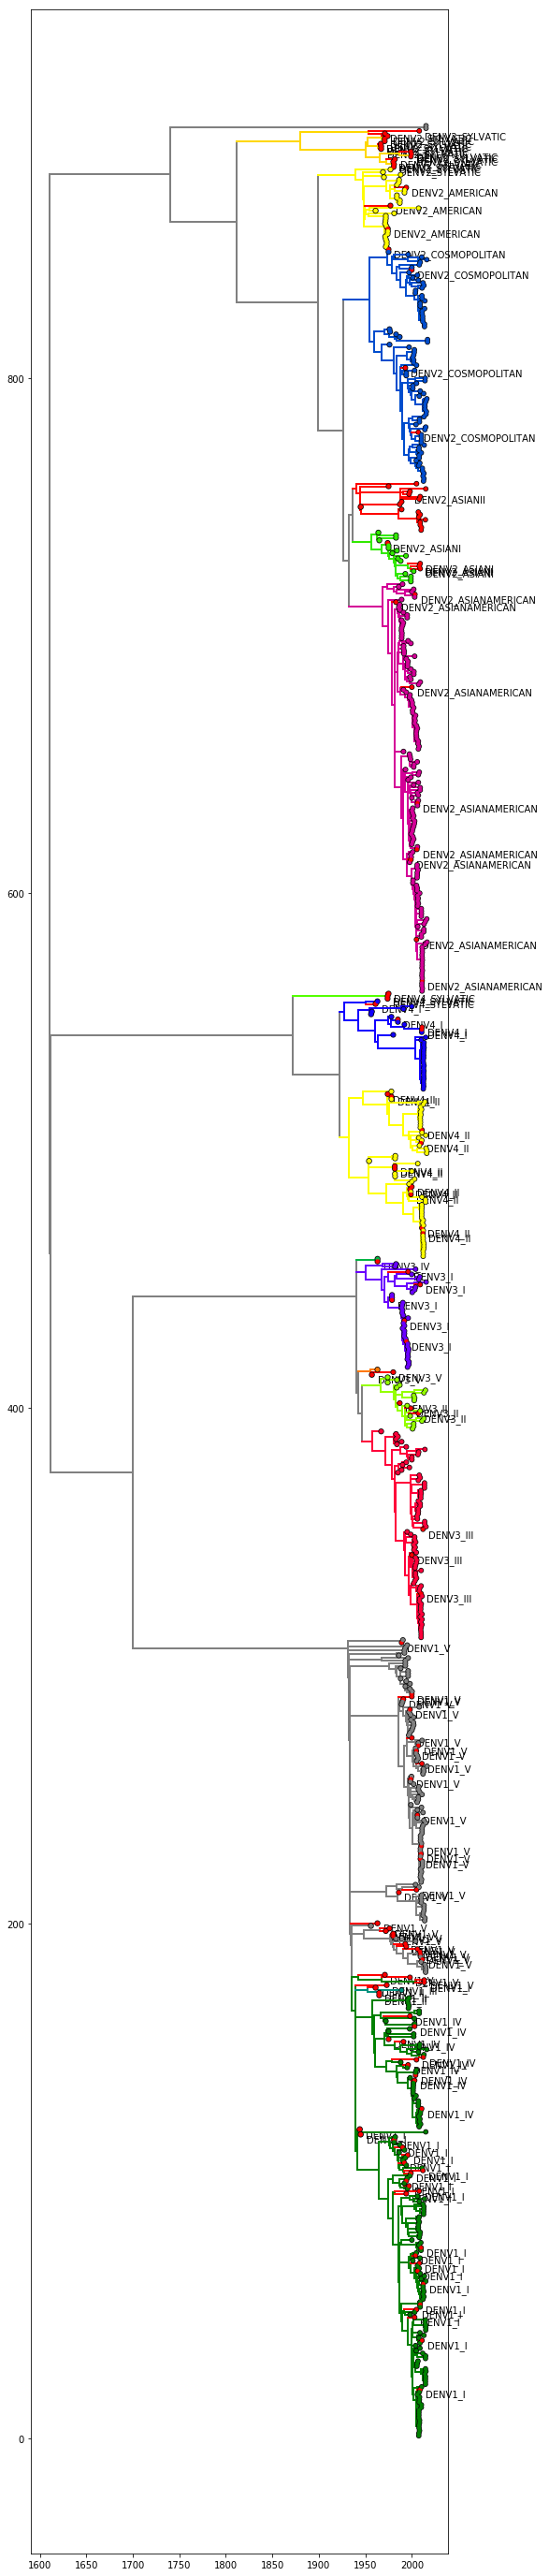

In [35]:
## Assign colors and plot

cm_subsection = linspace(0, 1, len(genotype_mrcas)) # [0, 0.2, 0.4, ...]
colors = [ cm.prism(x) for x in cm_subsection ] # [viridis[0], viridis[0.2], ...]
cmap = { genotype: color for (genotype, color) in zip(sorted(genotype_mrcas.keys()), colors)} # {'asianI': viridis[0], ...}
cmap['DENV1_I'] = 'green'
def plot_tree(ll):
    
    fig, ax = plt.subplots(figsize=(8,50))
    branchWidth=2 ## default branch width

    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if 'genotype' in k.traits:
            c = cmap[k.traits['genotype']]
        else:
            c = 'gray'
        
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            if is_genotype_reference(k):
                plt.text(x+6, y, ref_strains[k.traits['strain']], va='top')
                c = 'red'
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            if 'genotype' in k.traits and k.traits['genotype'] == 'DENV1_V':
                plt.text(x,y, k.index, ha='right')
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)


        plot_tree(tree)

In [46]:
treecopy = tree
for k in treecopy.Objects:
    if k.branchType=='node':
        k.traits['index'] = k.index

treestring = treecopy.toString(traits=['genotype', 'index'], numName = True)
open('./genotypetree.newick', 'w').write(treestring)

In [19]:
clade_designations = {}

seen = {'DENV1': [], 'DENV2': [], 'DENV3': [], 'DENV4': []}
duplicates = {'DENV1': [], 'DENV2': [], 'DENV3': [], 'DENV4': []}

for genotype, mrca in genotype_mrcas.items():
    clade_designations[genotype] = []
    serotype = genotype.split('/')[0]
    
    for gene in ['E', 'M', 'NS5', 'NS1']:
        
        for allele in mrca.traits['aa_muts'][gene]:
            
            site = int(allele[1:-1])
            allele = str(allele[-1])
            designation = (gene, site, allele)
            
            if designation in seen[serotype]:
                duplicates[serotype].append(designation)
            else:
                seen[serotype].append(designation)
                clade_designations[genotype].append(designation)

In [20]:
def proportion_monoallelic(node, designation, tree=tree):
    gene, site, allele = designation    
    subtree = tree.traverse_tree(node, include_all=True)
    n_changes = 0.

    for k in subtree:
        mut_sites = [ i[1:-1] for i in k.traits['aa_muts'][gene] ]
        n_changes += float(mut_sites.count(str(site)))
        
    proportion_monoallelic = 1. - (n_changes / float(len(subtree)))
    return proportion_monoallelic


def is_defining_allele(genotype, designation, min_proportion_monoallelic=0.9):
    serotype = genotype.split('/')[0]
    
    if designation in duplicates[serotype]:
        return False
    if proportion_monoallelic(genotype_mrcas[genotype], designation) < min_proportion_monoallelic:
        return False
    else:
        return True
    
def cleanup_designations(clade_designations=clade_designations):
    
    for genotype, alleles in clade_designations.items():
        
        # toss nonunique or frequently mutated sites
        valid_alleles = [a for a in alleles if is_defining_allele(genotype, a, min_proportion_monoallelic=0.6)] 
        
        # try and find three defining mutations in E and M
        preferred_alleles = sorted([a for a in valid_alleles if a[0] in ['E', 'M']],
                                   key = lambda a: proportion_monoallelic(genotype_mrcas[genotype], a), 
                                   reverse=True)

        # otherwise, pull from NS1 and NS5, preferentially keeping the most monoallelic mutations.
        if len(preferred_alleles) < 3:
            preferred_alleles += sorted([a for a in valid_alleles if a not in preferred_alleles],
                                   key = lambda a: proportion_monoallelic(genotype_mrcas[genotype], a), 
                                   reverse=True)
        if len(preferred_alleles) > 3:
            clade_designations[genotype] = preferred_alleles[:3]
        else:
            clade_designations[genotype] = preferred_alleles
        
    return clade_designations
        

In [21]:
clade_designations = cleanup_designations(clade_designations)

[('E', 297, 'T'), ('NS5', 135, 'M')]
[('E', 494, 'H'), ('NS1', 5, 'A')]
[('E', 484, 'I'), ('NS5', 688, 'I'), ('NS1', 222, 'N'), ('NS1', 247, 'L'), ('NS5', 135, 'I'), ('NS5', 866, 'A'), ('NS1', 264, 'I'), ('NS1', 281, 'D')]
[('E', 265, 'A'), ('E', 46, 'T'), ('NS1', 246, 'S'), ('NS5', 894, 'S'), ('NS1', 351, 'T')]
[('M', 57, 'A'), ('NS5', 750, 'K')]


In [23]:
serotype_genotype_designations = {
    'DENV1': {},
    'DENV2': {},
    'DENV3': {},
    'DENV4': {},
    'all': {}
}

for genotype, alleles in clade_designations.items():
    sero, geno = genotype.split('/')
    serotype_genotype_designations[sero][geno] = alleles
    serotype_genotype_designations['all'][genotype] = alleles
    
pprint(serotype_genotype_designations)

{'DENV1': {'I': [('E', 461, 'V'), ('E', 484, 'L'), ('M', 107, 'T')],
           'II': [('E', 345, 'A'), ('E', 432, 'M'), ('E', 439, 'V')],
           'IV': [('E', 339, 'S'), ('M', 72, 'E'), ('E', 88, 'T')],
           'V': [('E', 297, 'T'), ('NS5', 135, 'M')]},
 'DENV2': {'AMERICAN': [('E', 71, 'D'), ('E', 81, 'T'), ('E', 129, 'I')],
           'ASIANAMERICAN': [('E', 491, 'A'), ('M', 15, 'G'), ('M', 39, 'I')],
           'ASIANI': [('E', 484, 'I'), ('NS5', 688, 'I'), ('NS1', 222, 'N')],
           'COSMOPOLITAN': [('E', 71, 'A'), ('E', 149, 'N'), ('E', 462, 'V')],
           'SYLVATIC': [('E', 59, 'F'), ('E', 236, 'M'), ('E', 432, 'V')]},
 'DENV3': {'I': [('E', 233, 'K'), ('M', 128, 'F'), ('E', 68, 'V')],
           'II': [('M', 57, 'A'), ('NS5', 750, 'K')],
           'III': [('E', 303, 'T'), ('E', 454, 'V'), ('E', 132, 'Y')],
           'IV': [('E', 22, 'E'), ('E', 50, 'V'), ('E', 62, 'G')]},
 'DENV4': {'I': [('E', 494, 'H'), ('NS1', 5, 'A')],
           'II': [('E', 265, 'A'), ('E'